In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

/home/death-reaper/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.examples.tutorials.mnist import input_data

In [3]:
mnist_data = input_data.read_data_sets("mnist_hand_written_data/")

Extracting mnist_hand_written_data/train-images-idx3-ubyte.gz
Extracting mnist_hand_written_data/train-labels-idx1-ubyte.gz
Extracting mnist_hand_written_data/t10k-images-idx3-ubyte.gz
Extracting mnist_hand_written_data/t10k-labels-idx1-ubyte.gz


In [4]:
type(mnist_data)

tensorflow.contrib.learn.python.learn.datasets.base.Datasets

In [5]:
mnist_data

Datasets(train=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7f3d067be208>, validation=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7f3d067be1d0>, test=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7f3d067be128>)

In [6]:
def discriminator(X_img, is_var_scope_exist=False):
    
    with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE) as scope:
    
        ## First convolutional neural network
        disc_weight0 = tf.get_variable("disc_weight0", 
                                      [5, 5, 1, 32], 
                                      initializer=tf.truncated_normal_initializer(stddev=0.01))
        disc_bias0 = tf.get_variable("disc_bias0", 
                                    [32], 
                                    initializer = tf.constant_initializer(value=0))

        disc_conv_weight0 = tf.nn.conv2d(input=X_img, 
                                         filter=disc_weight0, 
                                         strides = [1, 1, 1, 1], 
                                         padding="SAME")

        disc_conv_weight0 = disc_conv_weight0 + disc_bias0
        disc_activated0 = tf.nn.relu(disc_conv_weight0)

        disc_conv_net0 = tf.nn.avg_pool(disc_activated0, 
                                     ksize=[1, 2, 2, 1], 
                                     strides = [1, 2, 2, 1], 
                                     padding="SAME")

        ## Second convolutional neural network
        disc_weight1 = tf.get_variable("disc_weight1", 
                                       [5, 5, 32, 64], 
                                       initializer = tf.truncated_normal_initializer(stddev = 0.01))

        disc_bias1 = tf.get_variable("disc_bias1", 
                                     [64], 
                                     initializer=tf.constant_initializer(value=0))

        disc_conv_weight1 = tf.nn.conv2d(input=disc_conv_net0, 
                                         filter = disc_weight1, 
                                         strides = [1, 1, 1, 1], 
                                         padding = "SAME")
        disc_conv_weight1 = disc_conv_weight1 + disc_bias1
        disc_activated1 = tf.nn.relu(disc_conv_weight1)
        disc_conv_net1 = tf.nn.avg_pool(disc_activated1, 
                                         ksize=[1,2,2,1], 
                                         strides=[1,2,2,1], 
                                         padding="SAME")

        ## First fully connected layer
        disc_weight3 = tf.get_variable("disc_weight3", 
                                       [7*7*64, 1024], 
                                       initializer=tf.truncated_normal_initializer(stddev=0.01))
        disc_bias3 = tf.get_variable("disc_bias3", 
                                     [1024], 
                                     initializer=tf.constant_initializer(value = 0))
        disc_conv_net1_reshaped = tf.reshape(disc_conv_net1, [-1, 7*7*64])

        disc_fully_con1 = tf.matmul(disc_conv_net1_reshaped, disc_weight3)
        disc_fully_con1 = disc_fully_con1 + disc_bias3
        disc_fully_con1 = tf.nn.relu(disc_fully_con1)

        ## Second fully connected layer
        disc_weight4 = tf.get_variable("disc_weight4", 
                                       [1024, 128], 
                                       initializer=tf.truncated_normal_initializer(stddev=0.01))
        disc_bias4 = tf.get_variable("disc_bias4", 
                                     [128], 
                                     initializer=tf.constant_initializer(value = 0))

        disc_fully_con2 = tf.matmul(disc_fully_con1, disc_weight4)
        disc_fully_con2 = disc_fully_con2 + disc_bias4
        
        ## Third fully connected layer
        disc_weight5 = tf.get_variable("disc_weight5", 
                                       [128, 1], 
                                       initializer=tf.truncated_normal_initializer(stddev=0.01))
        disc_bias5 = tf.get_variable("disc_bias5", 
                                     [1], 
                                     initializer=tf.constant_initializer(value = 0))

        disc_fully_con3 = tf.matmul(disc_fully_con2, disc_weight5)
        disc_fully_con3 = disc_fully_con3 + disc_bias5

        return disc_fully_con3


In [7]:
def generator(batch_size, noise_dim):
    
    with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE) as scope:
        
        noise = tf.truncated_normal([batch_size, noise_dim], name = "noise")

        ## deconvolutional neural network 0
        gen_weight0 = tf.get_variable("gen_weight0", 
                                      [noise_dim, 3136], 
                                      initializer=tf.truncated_normal_initializer(stddev = 0.01), 
                                      dtype = tf.float32)

        gen_bias0 = tf.get_variable("gen_bias0", 
                                    [3136], 
                                    initializer = tf.truncated_normal_initializer(stddev = 0.01))
        gen_network0 = tf.matmul(noise, gen_weight0) + gen_bias0
        gen_network0 = tf.reshape(gen_network0, [-1, 56, 56, 1])
        gen_network0 = tf.contrib.layers.batch_norm(gen_network0, epsilon=1e-5, scope = "bn0")
        gen_network0 = tf.nn.relu(gen_network0)

        ## deconvolutional neural network 1
        gen_weight1 = tf.get_variable("gen_weight1", 
                                      [3, 3, 1, noise_dim/2], 
                                      initializer=tf.truncated_normal_initializer(stddev = 0.01), 
                                      dtype = tf.float32)

        gen_bias1 = tf.get_variable("gen_bias1", 
                                    [noise_dim/2], 
                                    initializer = tf.truncated_normal_initializer(stddev = 0.01))
        gen_network1 = tf.nn.conv2d(input = gen_network0, 
                                    filter = gen_weight1, 
                                    strides = [1, 2, 2, 1], 
                                    padding = "SAME")
        gen_network1 = gen_network1 + gen_bias1
        gen_network1 = tf.contrib.layers.batch_norm(gen_network1, 
                                                    epsilon = 1e-5, 
                                                   scope = "bn1")
        gen_network1 = tf.nn.relu(gen_network1)
        gen_network1 = tf.image.resize_images(gen_network1, [56, 56])

        ## deconvolutional neural network 2
        gen_weight2 = tf.get_variable("gen_weight2", 
                                      [3, 3, noise_dim/2, noise_dim/4], 
                                      initializer = tf.truncated_normal_initializer(stddev=0.01), 
                                      dtype = tf.float32)
        gen_bias2 = tf.get_variable("gen_bias2", 
                                    [noise_dim/4], 
                                    initializer = tf.truncated_normal_initializer(stddev=0.01))

        gen_network2 = tf.nn.conv2d(input = gen_network1, 
                                    filter = gen_weight2, 
                                    padding = "SAME", 
                                    strides = [1, 2, 2, 1]) + gen_bias2
        gen_network2 = tf.contrib.layers.batch_norm(gen_network2, 
                                                    epsilon = 1e-5, 
                                                    scope = "bn2")
        gen_network2 = tf.nn.relu(gen_network2)
        gen_network2 = tf.image.resize_images(gen_network2, [56, 56])

        ## Producing one output dimensional channel
        gen_weight3 = tf.get_variable("gen_weight3", 
                                      [1, 1, noise_dim/4, 1], 
                                      initializer = tf.truncated_normal_initializer(stddev = 0.01), 
                                      dtype = tf.float32)
        gen_bias3 = tf.get_variable("gen_bias3", 
                                    [1], 
                                    initializer = tf.truncated_normal_initializer(stddev=0.01))

        gen_network3 = tf.nn.conv2d(input = gen_network2, 
                                    filter = gen_weight3, 
                                    strides = [1, 2, 2, 1], 
                                    padding = "SAME") + gen_bias3
        gen_network3 = tf.sigmoid(gen_network3)

        return gen_network3

In [8]:
tf_sess = tf.Session()

batches = 50
noise_dim = 100

X_placeholder = tf.placeholder(tf.float32, shape = [None, 28, 28, 1], name = "X_placeholder")

gen_func = generator(batches, noise_dim)
disc_func = discriminator(X_placeholder)
disc_gen_func = discriminator(gen_func)

cross_entropy_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits = disc_gen_func, 
                                                             labels = tf.ones_like(disc_gen_func))

gen_total_loss = tf.reduce_mean(cross_entropy_loss)

disc_X_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_func, 
                                                                     labels=tf.fill([batches, 1], 0.9)))
disc_gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_gen_func, 
                                                                       labels=tf.zeros_like(disc_gen_func)))
disc_total_loss = disc_X_loss + disc_gen_loss

train_variables = tf.trainable_variables()

disc_variables = [var for var in train_variables if "disc_" in var.name]
gen_variables = [var for var in train_variables if "gen_" in var.name]

with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE):
    
    disc_train_X = tf.train.AdamOptimizer(0.001).minimize(disc_X_loss, var_list = disc_variables)
    disc_train_fool_disc_gen = tf.train.AdamOptimizer(0.001).minimize(disc_gen_loss, var_list = disc_variables)
    gen_train = tf.train.AdamOptimizer(0.001).minimize(gen_total_loss, var_list=gen_variables)
    
disc_count_real = tf.placeholder(tf.float32)
disc_count_fake = tf.placeholder(tf.float32)
gen_count = tf.placeholder(tf.float32)
disc_after_train_fool = tf.reduce_mean(discriminator(generator(batches, noise_dim)))
disc_after_train_real = tf.reduce_mean(discriminator(X_placeholder))
images_tf = generator(batches, noise_dim)

tf.summary.scalar("Generator_loss", gen_total_loss)
tf.summary.scalar("Discriminator_fake_loss", disc_gen_loss)
tf.summary.scalar("Discriminator_real_loss", disc_X_loss)
tf.summary.scalar("discriminator_count_real", disc_count_real)
tf.summary.scalar("discriminator_count_fake", disc_count_fake)
tf.summary.scalar("generator_count", gen_count)
tf.summary.scalar("discriminator_values_of_generated", disc_after_train_fool)
tf.summary.scalar("discriminator_values_of_real", disc_after_train_real)
tf.summary.image("generated_fake_images", images_tf)

merged = tf.summary.merge_all()
logdir = "tensorboard/gan/"
fileWriter = tf.summary.FileWriter(logdir, graph = tf_sess.graph)

In [16]:
print(logdir + "\n\n")
print(merged + "\n\n")
print(str(disc_X_loss) + "\n\n")
print(str(disc_gen_loss) + "\n\n")
print(str(disc_total_loss) + "\n\n")
print(str(train_variables) + "\n\n")
print(str(gen_func) + "\n\n")
print(str(disc_gen_func) + "\n\n")
print(str(disc_variables) + "\n\n")
print(str(gen_variables) + "\n\n")
print(str(disc_after_train_fool) + "\n\n")
print(str(disc_after_train_real) + "\n\n")

tensorboard/gan/


Tensor("add_37:0", shape=(), dtype=string)
Tensor("Mean_1:0", shape=(), dtype=float32)


Tensor("Mean_2:0", shape=(), dtype=float32)


Tensor("add_14:0", shape=(), dtype=float32)


[<tf.Variable 'gen_weight0:0' shape=(100, 3136) dtype=float32_ref>, <tf.Variable 'gen_bias0:0' shape=(3136,) dtype=float32_ref>, <tf.Variable 'bn0/beta:0' shape=(1,) dtype=float32_ref>, <tf.Variable 'gen_weight1:0' shape=(3, 3, 1, 50) dtype=float32_ref>, <tf.Variable 'gen_bias1:0' shape=(50,) dtype=float32_ref>, <tf.Variable 'bn1/beta:0' shape=(50,) dtype=float32_ref>, <tf.Variable 'gen_weight2:0' shape=(3, 3, 50, 25) dtype=float32_ref>, <tf.Variable 'gen_bias2:0' shape=(25,) dtype=float32_ref>, <tf.Variable 'bn2/beta:0' shape=(25,) dtype=float32_ref>, <tf.Variable 'gen_weight3:0' shape=(1, 1, 25, 1) dtype=float32_ref>, <tf.Variable 'gen_bias3:0' shape=(1,) dtype=float32_ref>, <tf.Variable 'disc_weight0:0' shape=(5, 5, 1, 32) dtype=float32_ref>, <tf.Variable 'disc_bias0:0' shape=(32,) dtyp

TRAINING STEP:  0
Discriminator classified image:  [0.00046051]


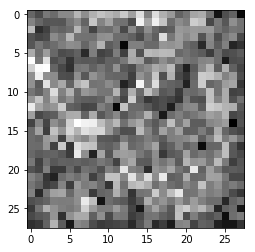

Discriminator classified image:  [0.00046085]


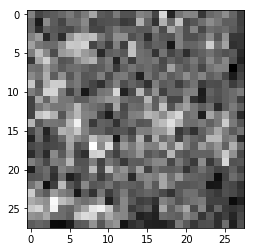

Discriminator classified image:  [0.00046013]


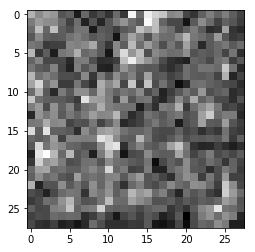

Discriminator classified image:  [0.00046133]


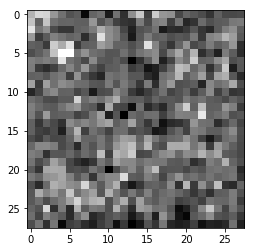

Discriminator classified image:  [0.00046046]


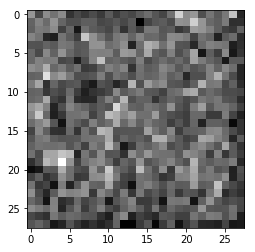

saved at models/pretrained_gan.ckpt-0
saved at models/pretrained_gan.ckpt-5000
TRAINING STEP:  10000
Discriminator classified image:  [34.979652]


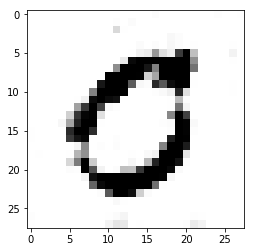

Discriminator classified image:  [32.489166]


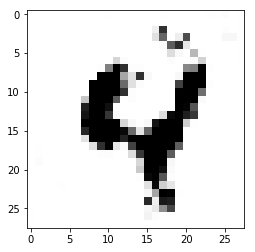

Discriminator classified image:  [38.69118]


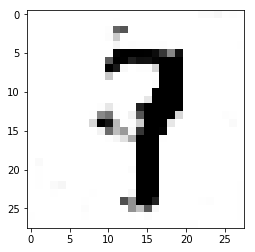

Discriminator classified image:  [-5.2069206]


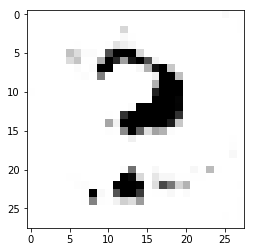

Discriminator classified image:  [4.5655937]


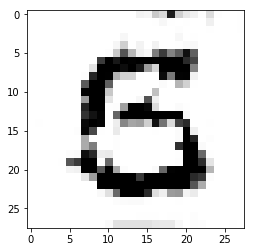

saved at models/pretrained_gan.ckpt-10000
saved at models/pretrained_gan.ckpt-15000


In [ ]:
saver = tf.train.Saver()
tf_sess.run(tf.global_variables_initializer())

genLoss = 0.0
discLossReal, discLossFake = 1.0, 1.0
discFakeCount, discRealCount, genCount = 0.0, 0.0, 0.0

for i in range(0, 50000):
    ori_batch = mnist_data.train.next_batch(batches)[0].reshape([batches, 28, 28, 1])
    if discLossFake > 0.6:
        _, discLossReal, discLossFake, genLoss = tf_sess.run([disc_train_fool_disc_gen, 
                                                              disc_X_loss, 
                                                              disc_gen_loss, 
                                                              gen_total_loss], 
                                                              {X_placeholder: ori_batch})
        discFakeCount += 1
        
    if genLoss > 0.5:
        _, discLossReal, discLossFake, genLoss = tf_sess.run([gen_train, 
                                                              disc_X_loss, 
                                                              disc_gen_loss, 
                                                              gen_total_loss], 
                                                              {X_placeholder: ori_batch})
        genCount += 1
        
    if discLossReal > 0.45:
        _, discLossReal, discLossFake, genLoss = tf_sess.run([disc_train_X, 
                                                              disc_X_loss, 
                                                              disc_gen_loss, 
                                                              gen_total_loss], 
                                                              {X_placeholder: ori_batch})
        discRealCount += 1
        
    if i%10 == 0:
        ori_batch = mnist_data.validation.next_batch(batches)[0].reshape([batches, 28, 28, 1])
        summary_validations = tf_sess.run(merged, feed_dict = {X_placeholder: ori_batch, 
                                       disc_count_real: discRealCount, 
                                       disc_count_fake: discFakeCount, 
                                       gen_count: genCount})
        fileWriter.add_summary(summary_validations, global_step=i)
        discRealCount, discFakeCount, genCount = 0.0, 0.0, 0.0
        
    if i%10000 == 0:
        generated_images = tf_sess.run(generator(5, noise_dim))
        disc_images = tf_sess.run(discriminator(X_placeholder), {X_placeholder: generated_images})
        print("TRAINING STEP: ", i)
        for j in range(0, 5):
            print("Discriminator classified image: ", disc_images[j])
            im = generated_images[j, :, :, 0]
            plt.imshow(im.reshape([28, 28]), cmap='Greys')
            plt.show()
    
    if i%5000 == 0:
        savedAt = saver.save(tf_sess, "models/pretrained_gan.ckpt", global_step = i)
        print("saved at {0}".format(savedAt))

In [40]:
ori_batch.dtype

dtype('float32')